# Fingerprint classification

This tutorial was adapted from from [Tensorflow tutorial Image Classification](https://www.tensorflow.org/tutorials/images/classification) and using the [SOCOFing data set from Kaggle](https://www.kaggle.com/datasets/ruizgara/socofing) to demonstrate different dataset, training and tuning strategies.

This notebook is designed to run on SageMaker notebook instances with a conda_tensorflow2_p38 kernel.

- Examine and understand data
- Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.
- Efficiently loading a dataset off disk.
- Build an input pipeline
- Build the model
- Train the model
- Test the model
- Improve the model and repeat the process

# Setup

In [1]:
# this directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
![ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"/model

import os
scratch_path = os.environ.get('SCRATCH', '../scratch')

env: SCRATCH=../scratch


# Data Preparation

## Create local directory

In [8]:
!mkdir $scratch_path/hand && $scratch_path/model

/usr/bin/sh: ../scratch/model: Is a directory


## Extract the data for training

In [9]:
!tar -xJf ./compressed_data/left.xz -C $scratch_path/hand/ && \
tar -xJf ./compressed_data/right.xz -C ../scratch/hand/ && \
tar -xJf ./compressed_data/real.xz -C ../scratch/ 

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'


## Set up AWS client

To access any AWS service with Boto3, we have to connect to it with a client. Here, we create an S3 client. We specify the region in which our data lives. We also have to pass the access key and the password

In [11]:
# 
# UPDATE HERE: your environment variables
#

# uncomment the below line to display the values for the Environment Variables. If not set, enter in the notebook image spawner prior to starting the server.
#!env | grep 'AWS\|S3\|ARN' | sort

In [12]:
#
# configure boto S3 connection
#

import boto3

aws_region = os.getenv('AWS_DEFAULT_REGION')                # enter your region name
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')          # enter your S3 access key ID
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')  # enter your S3 secret access key

# configure boto S3 connection
s3 = boto3.client('s3',
                  aws_region,
                  aws_access_key_id = aws_access_key_id,
                  aws_secret_access_key = aws_secret_access_key)

s3.list_buckets()

{'ResponseMetadata': {'RequestId': '3FHYH30YF6N5D9QS',
  'HostId': 'AfTbqGfNsZksoEEboJ2zwnxpeg+pDpwf7JEA/DWNJaY9tQ3t6d7nVbhZNLH19qILX5oxMS55ZrA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'AfTbqGfNsZksoEEboJ2zwnxpeg+pDpwf7JEA/DWNJaY9tQ3t6d7nVbhZNLH19qILX5oxMS55ZrA=',
   'x-amz-request-id': '3FHYH30YF6N5D9QS',
   'date': 'Thu, 15 Dec 2022 00:55:01 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'cluster-jknsf-k8gcr-image-registry-us-east-2-ovijdhnsyljgmserd',
   'CreationDate': datetime.datetime(2022, 12, 14, 18, 18, 49, tzinfo=tzlocal())},
  {'Name': 'xond-data',
   'CreationDate': datetime.datetime(2022, 12, 15, 0, 38, 10, tzinfo=tzlocal())}],
 'Owner': {'ID': '9d8720ea258c51d2e744dfc9537e6a52fadeee19915986c88122c7c5e62b1c1b'}}

## Create buckets in S3 to move training data

In [ ]:
# create a new bucket for storing the extracted training data for left hand fingerprints
s3.create_bucket(Bucket="left-fingerprints", CreateBucketConfiguration={'LocationConstraint': 'us-east-2'})

# create a new bucket for storing the extracted training data for right hand fingerprints
s3.create_bucket(Bucket="right-fingerprints", CreateBucketConfiguration={'LocationConstraint': 'us-east-2'})

# create a new bucket for storing the extracted training data for real fingerprints
s3.create_bucket(Bucket="real-fingerprints", CreateBucketConfiguration={'LocationConstraint': 'us-east-2'})

## Upload training data to S3

In [ ]:
def upload_files(path):
    session = boto3.Session(
        aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
        region_name=os.getenv('AWS_DEFAULT_REGION')
    )
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
 
    for subdir, dirs, files in os.walk(path):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(path)+1:], Body=data)
 
if __name__ == "__main__":
    upload_files('path/to/my/folder')

### Left fingerprints

In [ ]:
bucket_name = 'left-fingerprints'
upload_files(scratch_path + '/hand/left')

### Right fingerprints

In [ ]:
bucket_name = 'right-fingerprints'
upload_files(scratch_path + '/hand/right')

### Real fingerprints

In [ ]:
bucket_name = 'real-fingerprints'
upload_files(scratch_path + '/hand/real')

## Split the data into Train, Validation and Test

Keras utility generates a dataset from image files in a directory and infers the labels based on the parent folder. This utility will return a tf.data.Dataset that yields batches of images from the subdirectories left and right

```
hand/
...left/
......a_image_1.jpg
......a_image_2.jpg
...right/
......b_image_1.jpg
......b_image_2.jpg
```

In [13]:
#
# set variables for consistency
# 

img_height = 96              # desired height
img_width = 96               # desiredd width
batch_size = 32              # batch inputs in 32
seed_train_validation = 42   # Must be same for train_ds and val_ds
validation_split = 0.3       # move 30% of the data into validation

### Create Train

Train is the sample of data used to fit the model. 

In [16]:
!pip install tensorflow -q
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../scratch/hand',
    labels='inferred',
    label_mode = "categorical", 
    class_names=['left','right'],
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=seed_train_validation,
    validation_split=validation_split,
    subset='training'
)

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
Found 17953 files belonging to 2 classes.
Using 12568 files for training.


### Create Validation

Validation is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

In [17]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../scratch/hand',
    labels='inferred',
    label_mode = "categorical", 
    class_names=['left','right'],
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=seed_train_validation,
    validation_split=validation_split,
    subset='validation'
)

Found 17953 files belonging to 2 classes.
Using 5385 files for validation.


## Create Test

The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [18]:
# splits the validation_ds into validation and test data
test_ds = validation_ds.take(16)
validation_ds = validation_ds.skip(16)

## Print the Dataset batches

In [19]:
# reserves 393 batches training
print('70% of data in batches of 32 images for training -->', train_ds.cardinality())
# reserves 164 batches validation
print('20% of data in batches of 32 images for validating -->', validation_ds.cardinality())
# reserves 5 batches testing
print('10% of data in batches of 32 images for testing -->', test_ds.cardinality())

70% of data in batches of 32 images for training --> tf.Tensor(393, shape=(), dtype=int64)
20% of data in batches of 32 images for validating --> tf.Tensor(153, shape=(), dtype=int64)
10% of data in batches of 32 images for testing --> tf.Tensor(16, shape=(), dtype=int64)


## Print Inferred Dataset Classes

In [20]:
# display the class names inferred from the training dataset

class_names = train_ds.class_names
print(class_names)

['left', 'right']


## Print Fingerprint Data Samples

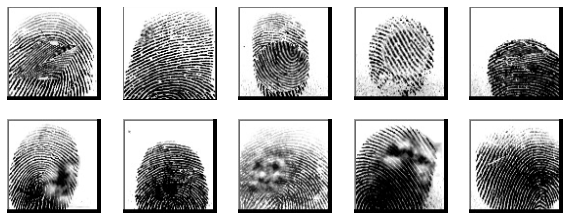

In [21]:
# show the first 10 images in the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    #TODO update labels
    #plt.title(class_names[labels[i]])
    plt.axis("off")

## Apply augmentation

When you don't have a large image dataset or when your images are all set in a single direction like ours are, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. Learn more https://www.tensorflow.org/tutorials/images/data_augmentation

In [22]:
data_augmentation = tf.keras.Sequential([

  # randomly rotates images during training
  tf.keras.layers.RandomRotation(
    # a float represented as fraction of 2 Pi, or a tuple of size 2 representing lower and upper bound for rotating clockwise and counter-clockwise. 
    # A positive values means rotating counter clock-wise, while a negative value means clock-wise. 
    0.2,
      
    # Points outside the boundaries of the input are filled according to the given mode (one of {"constant", "reflect", "wrap", "nearest"}).
    fill_mode='constant',
      
    # Supported values: "nearest", "bilinear".
    interpolation='nearest',
      
    # Integer. Used to create a random seed.
    seed=None,
      
    # the value to be filled outside the boundaries when fill_mode="constant".
    fill_value=0.0,
),
])

Visualize a few augmented examples by applying data augmentation to the same image several times:Visualize a few augmented examples by applying data augmentation to the same image several times:

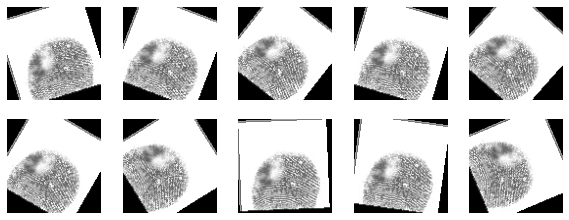

In [23]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[2]
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 1, cmap='gray')
    plt.axis('off')

## Configure the datasets for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

1. `Caching` a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
1. `Prefetching` overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training

## Define a training strategy

tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes.
- Easy to use and support multiple user segments, including researchers, machine learning engineers, etc.
- Provide good performance out of the box.
- Easy switching between strategies.

### Mirrored Strategy 

Supports synchronous distributed training on multiple GPUs on one machine. It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. 

In [25]:
#
# uncomment to reate a MirroredStrategy.
# 

#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
#strategy = tf.distribute.MirroredStrategy()

### Multi-Worker Mirrored Strategy

Multi-Worker MirroredStrategy is very similar to MirroredStrategy. It implements synchronous distributed training across multiple workers, each with potentially multiple GPUs. Similar to tf.distribute.MirroredStrategy, it creates copies of all variables in the model on each device across all workers.

MultiWorkerMirroredStrategy has two implementations for cross-device communications. 
1. CommunicationImplementation.RING is RPC-based and supports both CPUs and GPUs. 
1. CommunicationImplementation.NCCL uses NCCL and provides state-of-art performance on GPUs but it doesn't support CPUs. 
1. CollectiveCommunication.AUTO defers the choice to Tensorflow. You can specify them in the following way:

In [26]:
#
# uncomment to create a Multi-worker Mirrored Strategy
#

communication_options = tf.distribute.experimental.CommunicationOptions(
    # RING is RPC-based and supports both CPUs and GPUs.
    #implementation=tf.distribute.experimental.CommunicationImplementation.RING)

    # NCCL uses NCCL and provides state-of-art performance on GPUs but it doesn't support CPUs
    #implementation=tf.distribute.experimental.CommunicationImplementation.NCCL)
    
    # AUTO defers the choice to Tensorflow.
    implementation=tf.distribute.experimental.CommunicationImplementation.AUTO)
strategy = tf.distribute.MultiWorkerMirroredStrategy(communication_options=communication_options)

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [27]:
#
# Understand the number of devices and GPU available
#

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Number of devices: 1
GPU is NOT AVAILABLE


## Define a model and hyperparameters

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a hypermodel.

In [29]:
#
# A model definition that doesn't take advantage of a training strategy
#
!pip install keras-tuner -q
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt

num_classes = len(class_names)
model_path = scratch_path + '/model'

inputShape=(img_height, img_width, 1)

def model_builder(hp):
    model = keras.Sequential()
    data_augmentation
    input_shape=(img_height, img_width, 1)
    chanDim = -1
    # first CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_1", min_value=32, max_value=96, step=32),
        (3, 3), padding="same", input_shape=inputShape, data_format="channels_last"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # second CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_2", min_value=64, max_value=128, step=32),
        (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # third CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_3", min_value=96, max_value=256, step=32),
        (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=256,
                           max_value=768, step=256)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    # initialize the learning rate choices and optimizer
    lr = hp.Choice("learning_rate",
                   values=[1e-1, 1e-2, 1e-3])
    # compile the model
    model.compile(optimizer='adam', loss="categorical_crossentropy",
                  metrics=["accuracy"])
    # return the model
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.losses.CategoricalCrossentropy(from_logits=True),
        # metrics to be evaluated by the model during training and testing.The strings 'accuracy' or 'acc', TF converts this to binary, categorical or sparse.
        metrics=['accuracy'],
    )
    return model

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


## Search hyperparameters

The Keras Tuner has four tuners available:
1. RandomSearch
1. Hyperband
1. BayesianOptimization
1. Sklearn. 

In this tutorial, you use the Hyperband tuner. The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. 

To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [30]:
num_classes = len(class_names)
model_path = scratch_path + '/model'

# Open a strategy scope.
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    # nteger, the maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected epochs to convergence for your largest Model, and to use early stopping during trainin
    max_epochs=2,
    # Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
    factor=3,
    # training strategy
    distribution_strategy=strategy,
    directory=scratch_path + '/model/model_hp',
    project_name='hypertune',
    #  If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
    # To disable this behavior, pass an additional overwrite=True argument while instantiating the tuner.
    overwrite=True
)

We’ll be using EarlyStopping to short circuit hyperparameter trials that are not performing well. Keep in mind that tuning hyperparameters is an extremely computationally expensive process, so if we can kill off poorly performing trials, we can save ourselves a bunch of time.

In [31]:
# Stop training when a monitored metric has stopped improving.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode="auto")

In [1]:
tuner.search(train_ds, epochs=4, validation_data=validation_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] optimal number of filters in conv_1 layer: {}".format(
	best_hps.get("conv_1")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	best_hps.get("conv_2")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	best_hps.get("conv_3")))
print("[INFO] optimal number of units in dense layer: {}".format(
	best_hps.get("dense_units")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))

NameError: name 'tuner' is not defined

## Fit a model

Fit the model with the optimal hyperparameters and train it on the data for 50 epochs


In [ ]:
epochs = 10

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=validation_ds,
    epochs=epochs,
    workers=1,
    use_multiprocessing=False
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

## Print the model layers

In [ ]:
model.summary()

## Evaluate the model

In [ ]:
model.evaluate(
    test_ds,
    batch_size=batch_size,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

# Save the model

You can save an entire model to a single artifact. It will include:

- The model's architecture/config
- The model's weight values (which were learned during training)
- The model's compilation information (if compile() was called)
- The optimizer and its state, if any (this enables you to restart training where you left)

There are two formats you can use to save an entire model to disk: the TensorFlow SavedModel format, and the older Keras H5 format.

## Locally

In [ ]:
# older Keras H5 format
model.save( scratch_path + '/model/hand_prediction.h5')

In [ ]:
# TensorFlow SavedModel format
model.save( scratch_path + '/model/hand_prediction.tf')

## S3 

# Make a prediction

## Load the model

In [ ]:
model = keras.models.load_model( scratch_path + '/model/hand_prediction.tf')

## Load a new fingerprint

In [ ]:
# un/comment test a left finger
#path = scratch_path + '/real/10__M_Left_thumb_finger.png'

# un/comment test a right finger
path = scratch_path + '/real/1__M_Right_ring_finger.png'


# Loads an image into PIL format.
img = tf.keras.utils.load_img(
    path,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    interpolation='nearest',
    keep_aspect_ratio=False
)

plt.imshow(img, cmap='gray')

## Convert the image

In [ ]:
# Converts a PIL Image instance to a Numpy array.
img_array = tf.keras.utils.img_to_array(img)

# Returns a tensor with a length 1 axis inserted at index axis.
#img_array = tf.expand_dims(img_array, 0)

## Predict

In [ ]:
# perform a prediction on the new fingerprint
predictions = model.predict(img_array)

In [ ]:
import numpy as np

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)